<ipython-input-2-6a443da2f752>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data = df['Approx. Total Revenue(INR)'].resample('M').sum()


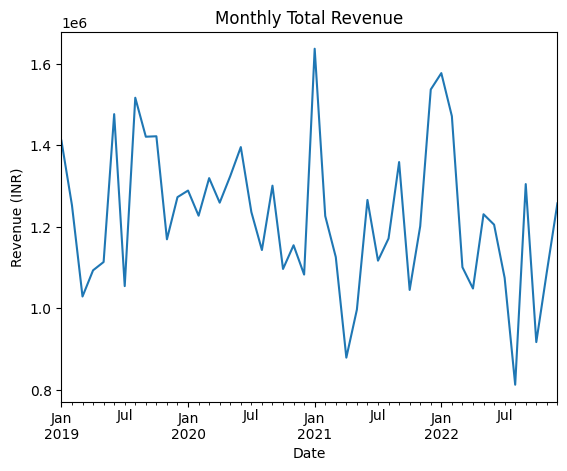

Best Model: SARIMAX(1, 1, 0) x (1, 1, 0, 12) with AIC 952.2497298769076
MAPE: 7.01%
Accuracy: 92.99%


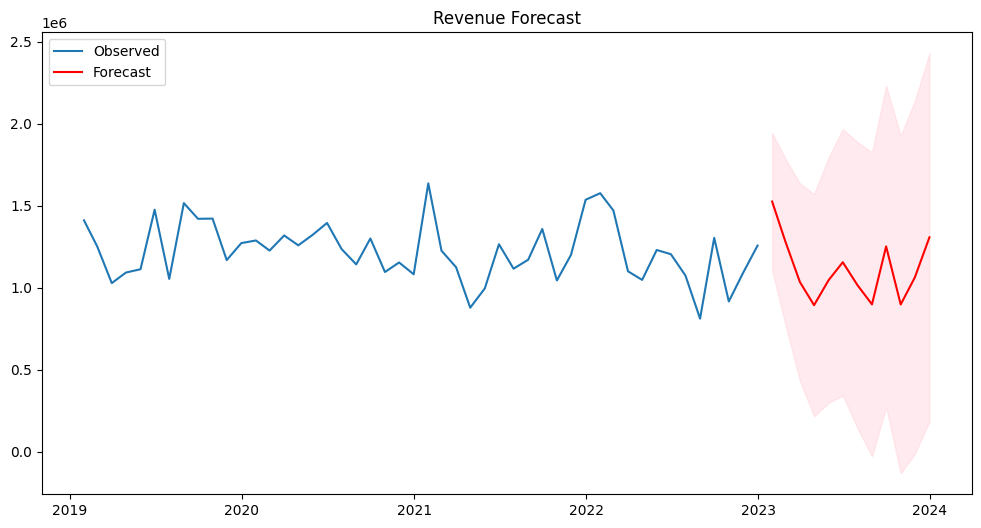

                 Date  Forecasted Revenue
2023-01-31 2023-01-31        1.526660e+06
2023-02-28 2023-02-28        1.283847e+06
2023-03-31 2023-03-31        1.035628e+06
2023-04-30 2023-04-30        8.948482e+05
2023-05-31 2023-05-31        1.047710e+06
2023-06-30 2023-06-30        1.156562e+06
2023-07-31 2023-07-31        1.017608e+06
2023-08-31 2023-08-31        8.997351e+05
2023-09-30 2023-09-30        1.253126e+06
2023-10-31 2023-10-31        8.990594e+05
2023-11-30 2023-11-30        1.064222e+06
2023-12-31 2023-12-31        1.308616e+06


In [2]:
# main
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

df = pd.read_csv('/content/dairy_dataset 2 copy.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

ts_data = df['Approx. Total Revenue(INR)'].resample('M').sum()

ts_data.plot(title='Monthly Total Revenue', ylabel='Revenue (INR)', xlabel='Date')
plt.show()

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # 12 months revenue calculations


warnings.filterwarnings('ignore')
best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(ts_data, order=param, seasonal_order=seasonal_param, enforce_stationarity=True, enforce_invertibility=True)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f'Best Model: SARIMAX{best_params[0]} x {best_params[1]} with AIC {best_aic}')

model = sm.tsa.statespace.SARIMAX(ts_data, order=best_params[0], seasonal_order=best_params[1], enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()

forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(ts_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted Revenue': forecast_values})
forecast_df.to_csv('/content/forecasted_revenue.csv', index=False)

actual_values = ts_data[-12:]
if len(actual_values) == len(forecast_values[:len(actual_values)]):
    mape = mean_absolute_percentage_error(actual_values, forecast_values[:len(actual_values)])
    accuracy = 100 - (mape * 100)
    print(f'MAPE: {mape:.2%}')
    print(f'Accuracy: {accuracy:.2f}%')
else:
    print("Insufficient actual values for MAPE calculation.")

plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Revenue Forecast')
plt.show()

print(forecast_df)